e:\anaconda\envs\torch\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


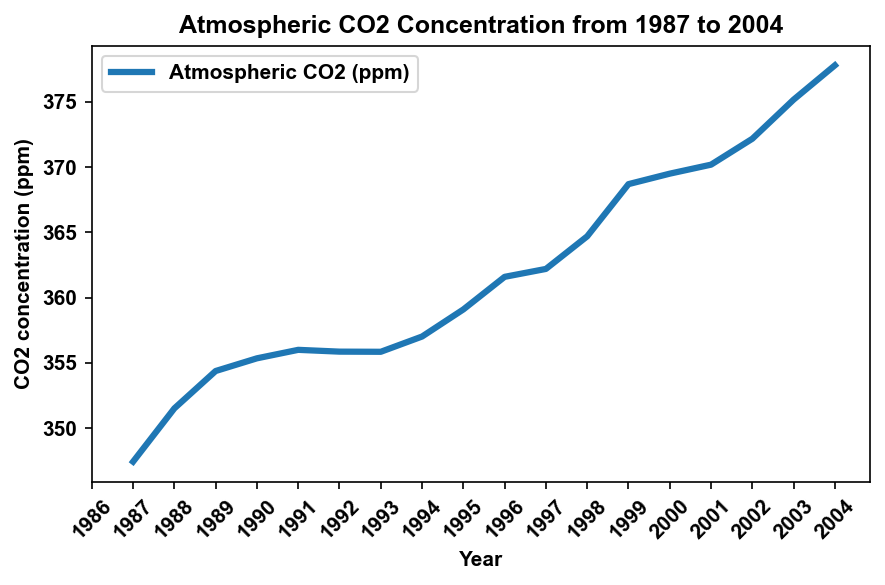

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# 设置字体样式和大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10

# 加载CO2排放数据集
# Loading the CO2 emission dataset
co2_emissions = pd.read_excel('data/Global_Carbon_Budget_2016_v1.0.xlsx', sheet_name='Global Carbon Budget')
co2_emissions.columns = co2_emissions.iloc[20] # Using row 20 as headers
co2_emissions = co2_emissions.iloc[21:] # Skipping rows before the data starts
co2_emissions = co2_emissions[['Year', 'fossil fuel and cement emissions', 'land-use change emissions','ocean sink','land sink','atmospheric growth']]
co2_emissions = co2_emissions[(co2_emissions['Year'] >= 1987) & (co2_emissions['Year'] <= 2004)]
co2_emissions['total_emissions'] = co2_emissions['fossil fuel and cement emissions'] + co2_emissions['land-use change emissions'] - co2_emissions['ocean sink'] - co2_emissions['land sink']
yearly_emissions = dict(zip(co2_emissions['Year'], co2_emissions['total_emissions']))


# 模型的常数
k12 = 105/740  # 大气到海洋的转移系数
k21 = 102/900  # 海洋到大气的转移系数

# 1986年的初始值，单位为PgC
N1_initial = 740  # 大气中的碳含量
N2_initial = 900  # 海洋表面的碳含量

# 将PgC转换为ppm
N1_initial_ppm = N1_initial/2.13  # PgC到ppm的转换因子
N2_initial_ppm = N2_initial/2.13

# 模型的微分方程
def model_no_buffer(N, t, k12, k21, yearly_emissions):
    N1, N2 = N
    year = int(t)
    gamma = yearly_emissions.get(year, 0) # Default to 0 if year is not in the dataset
    dN1dt = -k12 * N1 + k21 * N2 + gamma
    dN2dt = k12 * N1 - k21 * N2
    return [dN1dt, dN2dt]


# 解决微分方程
years = np.arange(1987, 2005)
N0 = [N1_initial_ppm, N2_initial_ppm]
solution = odeint(model_no_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm = solution[:, 0]

# 绘制结果
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(years, N1_ppm, label="Atmospheric CO2 (ppm)", linewidth=3)

plt.xticks(np.arange(1986, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 concentration (ppm)", weight='bold')
plt.title("Atmospheric CO2 Concentration from 1987 to 2004",weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

e:\anaconda\envs\torch\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


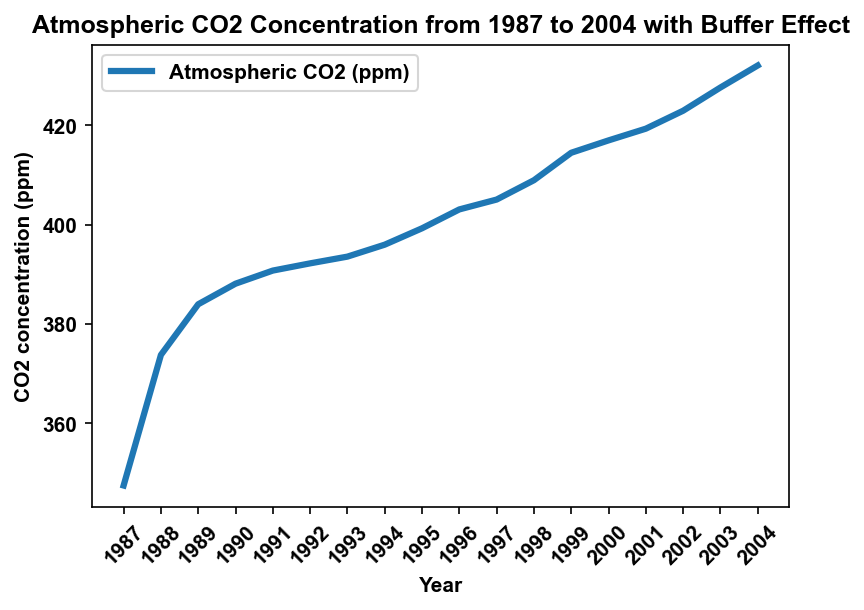

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

co2_emissions = pd.read_excel('data/Global_Carbon_Budget_2016_v1.0.xlsx', sheet_name='Global Carbon Budget')
co2_emissions.columns = co2_emissions.iloc[20] # Using row 20 as headers
co2_emissions = co2_emissions.iloc[21:] # Skipping rows before the data starts
co2_emissions = co2_emissions[['Year', 'fossil fuel and cement emissions', 'land-use change emissions','ocean sink','land sink','atmospheric growth']]
co2_emissions = co2_emissions[(co2_emissions['Year'] >= 1987) & (co2_emissions['Year'] <= 2004)]
co2_emissions['total_emissions'] = co2_emissions['fossil fuel and cement emissions'] + co2_emissions['land-use change emissions'] - co2_emissions['ocean sink'] - co2_emissions['land sink']
yearly_emissions = dict(zip(co2_emissions['Year'], co2_emissions['total_emissions']))


# 模型的常数
k12 = 105/740  # 大气到海洋的转移系数
k21 = 102/900  # 海洋到大气的转移系数

# 1986年的初始值，单位为PgC
N1_initial = 740  # 大气中的碳含量
N2_initial = 900  # 海洋表面的碳含量

# 将PgC转换为ppm
N1_initial_ppm = N1_initial/2.13  # PgC到ppm的转换因子
N2_initial_ppm = N2_initial/2.13

# 计算缓冲因子的函数


def calculate_buffer_factor(z):
     
    return z*1.72208
# 对列表中的每个浓度值计算缓冲因子
buffer_factors = calculate_buffer_factor(co2_emissions['atmospheric growth'])


yearly_buffer_factors = dict(zip(co2_emissions['Year'], buffer_factors))
# 模型的微分方程，包含缓冲效应
def model_with_buffer(N, t, k12, k21, yearly_emissions):
    N1, N2 = N
    year = int(t)
    gamma = yearly_emissions.get(year, 0) # Default to 0 if year is not in the dataset
    dN1dt = -k12 * N1 + k21 * (821/2.13 + (3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2-821/2.13)) + gamma
    dN2dt = k12 * N1 - k21 * (821/2.13 + (3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2-821/2.13))
    return [dN1dt, dN2dt]

# 解决微分方程
years = np.arange(1987, 2005)
N0 = [N1_initial_ppm, N2_initial_ppm]
solution = odeint(model_with_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm = solution[:, 0]

# 绘制结果
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(years, N1_ppm, label="Atmospheric CO2 (ppm)", linewidth=3)
plt.xticks(np.arange(1987, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 concentration (ppm)", weight='bold')
plt.title("Atmospheric CO2 Concentration from 1987 to 2004 with Buffer Effect", weight='bold')
plt.legend()
plt.show()


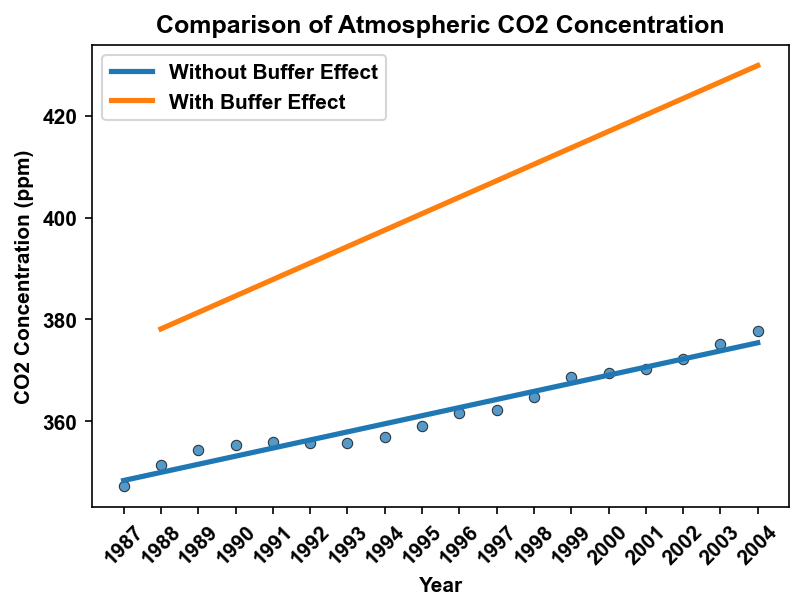

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# 你之前定义的模型参数和函数
# ...

# 解决1.1问题的微分方程（不包含缓冲效应）
solution_no_buffer = odeint(model_no_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 解决1.2问题的微分方程（包含缓冲效应）
solution_with_buffer = odeint(model_with_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm_no_buffer = solution_no_buffer[:, 0]
N1_ppm_with_buffer = solution_with_buffer[:, 0]
# Fit linear regression line to the data
linear_regression_no_buffer = np.polyfit(years, N1_ppm_no_buffer, 1)
linear_regression_with_buffer = np.polyfit(years[1:], N1_ppm_with_buffer[1:], 1)

# Generate the linear regression line
linear_regression_line_no_buffer = np.polyval(linear_regression_no_buffer, years)

linear_regression_line_with_buffer = np.polyval(linear_regression_with_buffer, years[1:])


# Plot the data with linear regression lines
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(years, N1_ppm_no_buffer,  s=25,marker='o',linewidths=0.5,edgecolors='black',alpha=0.75)
# plt.scatter(years, N1_ppm_with_buffer, label="With Buffer Effect", s=50, marker='x')
plt.plot(years, linear_regression_line_no_buffer, label="Without Buffer Effect", linewidth=2.5)
plt.plot(years[1:], linear_regression_line_with_buffer, label="With Buffer Effect", linewidth=2.5)


plt.xticks(np.arange(1987, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 Concentration (ppm)", weight='bold')
plt.title("Comparison of Atmospheric CO2 Concentration", weight='bold')
plt.legend()
plt.show()

